# Phylogenetic Distance Calculation from RhizCG 2013

Notes: Calculate phylogenetic distance using phylogeny created from rbcL and matK in phylogenerator 20160209_phylogeny.tre.  

# Init

In [22]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [23]:
%%R
library(foreach)
#library(lsmeans)
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(phyloseq)
library(doParallel)


In [24]:
%%R
# Initialize corMLPE 
source('/home/bryan/corMLPE/corMLPE.R')

## Set file locations

In [25]:
%%R
workDir = '/home/bryan/RhizCG/PhyDist/'
treeFile = '/home/bryan/RhizCG/PhyDist/20160209_phylogeny.tre'
NAMFile = '/home/bryan/RhizCG/PhyDist/NAM_founders_distanceMatrix_v2.txt'

### Read  tables table 

In [26]:
%%R 

NAMdist = read.table(NAMFile, header = TRUE)
#reorder so that NAMdist is in same order as log2fold change matrix
NAMdist = NAMdist[c(1:6, 8, 7, 9, 10), c(1:6, 8, 7, 9, 10)]

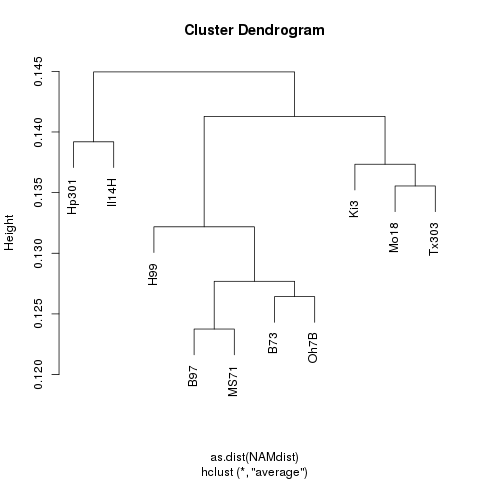

In [27]:
%%R
NAM_hc = hclust(as.dist(NAMdist), "average")
plot(NAM_hc)

In [28]:
%%R
#Read rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)

physeq.NAM = subset_samples(physeq.Full, Treatment == "Nneg" & Type == "Maize" & Plant != "75-062")
physeq.NAM

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## NAM lines clustered by sampling date

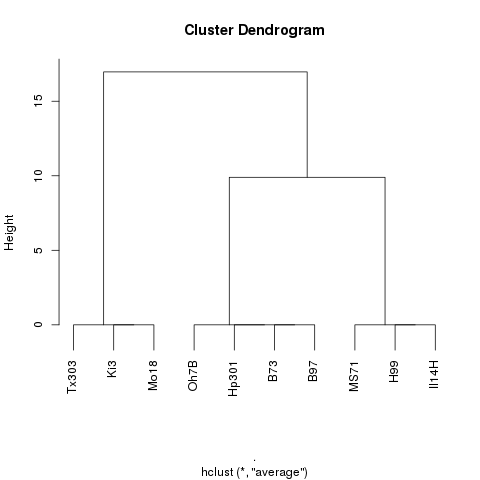

In [29]:
%%R
temp = sample_data(physeq.NAM) %>% 
    as(., "data.frame") %>% 
    group_by(Plant) %>% 
    summarize(DAY = mean(DAP)) #%>%
row.names(temp) = temp$Plant
dist(temp, method = "euclidean") %>%
    hclust("average") %>%
     plot

## Calculate w-Unifrac distances

In [30]:
%%R
registerDoParallel(cores=28)
phy.wunif.dist = distance(physeq.NAM, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

## Create melted dataframes for plot by plot comparisons

In [31]:
%%R
gd.m = melt(as.matrix(NAMdist))

#set column names and create comparison column
colnames(gd.m) = c("PlantA", "PlantB", "gene_Dist")
gd.m$PlantComp = paste(gd.m$PlantA, gd.m$PlantB, sep = "-")
gd.m %>% head


  PlantA PlantB gene_Dist PlantComp
1    B73    B73 0.0000000   B73-B73
2    B97    B73 0.1285456   B97-B73
3    H99    B73 0.1306701   H99-B73
4  Hp301    B73 0.1357241 Hp301-B73
5  Il14H    B73 0.1412994 Il14H-B73
6    Ki3    B73 0.1413460   Ki3-B73


In [32]:
%%R
ud = as.matrix(phy.wunif.dist) 
# remove lower triangle to remove duplicate values
ud[ lower.tri( ud, diag = TRUE ) ]  <- NA
head(ud)
ud.m = melt(ud, na.rm= TRUE)
colnames(ud.m) = c("PlotA", "PlotB", "w_Unif_Dist")
head(ud.m) %>% print
dim(ud.m) %>% print

                PlotA             PlotB w_Unif_Dist
41  sample5-2.06_Nneg sample6-2.26_Nneg   0.1544908
81  sample5-2.06_Nneg sample6-3.18_Nneg   0.1652106
82  sample6-2.26_Nneg sample6-3.18_Nneg   0.1568328
121 sample5-2.06_Nneg sample5-3.13_Nneg   0.1293945
122 sample6-2.26_Nneg sample5-3.13_Nneg   0.1576011
123 sample6-3.18_Nneg sample5-3.13_Nneg   0.1265751
[1] 780   3


## Create functional distance variable

In [33]:
%%R
#add growing degree days
DAP = c(36, 53, 57, 61, 72, 79, 84, 88)
GDD = c(795.1, 1089.4, 1136.8, 1199.5, 1394.3, 1512.4, 1573.8, 1625.6)
M_GDD = cbind(DAP, GDD) %>% as.data.frame
M_GDD

Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric
(SS)

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
    Plant SeedSize_mg
1   ERATE      0.0035
2   HELAN     90.0000
3     B73    333.0000
4   FAGES     38.0000
5   AMAPO      0.4900
6  SORSUD     10.7000
7   SORBI     32.3900
8   ELCOR      3.2000
9   ECHCG      1.5800
10  ABUTH      9.6000
11  SETFA      1.8000
12  GLYMA    174.0000
13   MS71      0.2640
14   Mo18      0.2240
15  Il14H      0.2190
16  Tx303      0.2790
17   Oh7B      0.2070
18    B97      0.2400
19  Hp301      0.0869
20 75-062      0.2220
21    Ki3      0.2280
22    H99      0.2310


 [1] "B73"   "B97"   "H99"   "Hp301" "Il14H" "Ki3"   "Mo18"  "MS71"  "Oh7B" 
[10] "Tx303"
Importance of components:
                          PC1    PC2    PC3     PC4
Standard deviation     1.4160 1.2049 0.7101 0.19689
Proportion of Variance 0.5013 0.3630 0.1261 0.00969
Cumulative Proportion  0.5013 0.8642 0.9903 1.00000
                      PC1         PC2        PC3         PC4
SeedSize_mg    0.37559025  0.54897881 -0.7444181 -0.05827502
M_Resid_logN   0.62885977 -0.35501908  0.1089487 -0.68310104
M_Resid_logCN -0.01315932  0.75565140  0.5751346 -0.31311015
M_Resid_logB   0.68065717  0.03968222  0.3212353  0.65722068


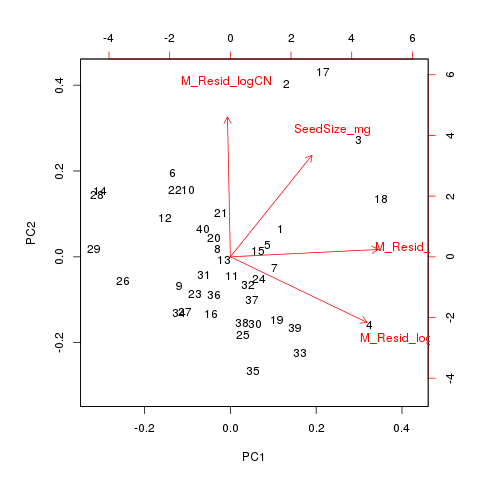

In [34]:
%%R
# PCA of maize
sd = as(sample_data(physeq.NAM), "data.frame")
sd$Plant %>% levels %>% print
sd = left_join(sd, SS, by = "Plant")
sd = left_join(sd, M_GDD, by = "DAP")

 fit = prcomp(~SeedSize_mg + M_Resid_logN + M_Resid_logCN + M_Resid_logB, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

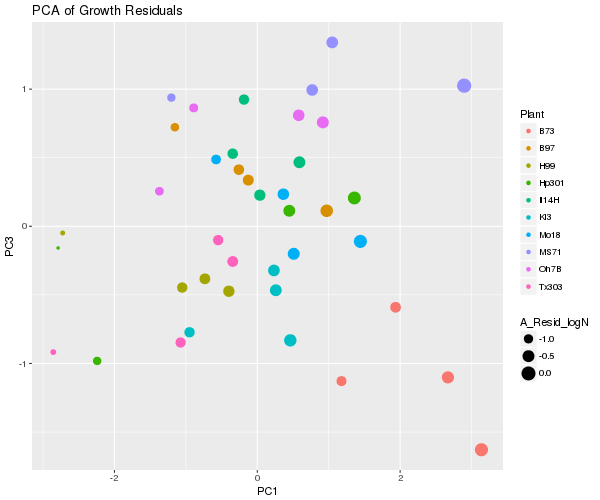

In [35]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sd, S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(physeq.NAM) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC3, colour = Plant, 
                       size = A_Resid_logN), pch = 21)
p = p + geom_point()
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

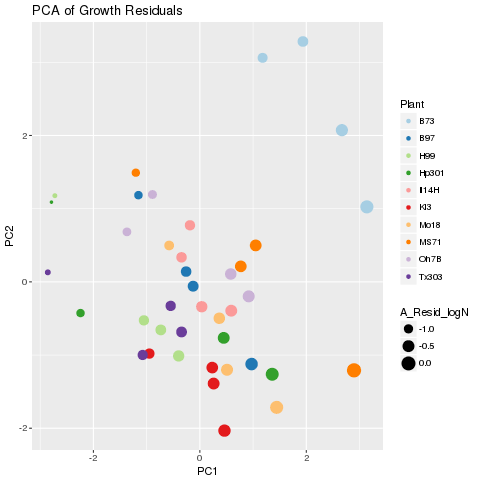

In [36]:
%%R
p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = A_Resid_logN), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [37]:
%%R
#measure distances on PC1
sd = sample_data(physeq.NAM)
PC1dist = dist(sd[, "PC1"], method = "euclidian")
    #melt matrix
    PC1.m = melt(as.matrix(PC1dist))

    #set column names and create comparison column
     colnames(PC1.m) = c("PlotA", "PlotB", "PC1Dist")
    PC1.m$PlotComp = paste(PC1.m$PlotA, PC1.m$PlotB, sep = "-")
    PC1.m %>% head

#measure distances on PC2
PC2dist = dist(sd[,"PC2"], method = "euclidian")
    #melt matrix
    PC2.m = melt(as.matrix(PC2dist))

    #set column names and create comparison column
     colnames(PC2.m) = c("PlotA", "PlotB", "PC2Dist")
    PC2.m$PlotComp = paste(PC2.m$PlotA, PC2.m$PlotB, sep = "-")
    PC2.m %>% head

#measure distances on PC3
PC3dist = dist(sd[,"PC3"], method = "euclidian")
    #melt matrix
    PC3.m = melt(as.matrix(PC3dist))

    #set column names and create comparison column
     colnames(PC3.m) = c("PlotA", "PlotB", "PC3Dist")
    PC3.m$PlotComp = paste(PC3.m$PlotA, PC3.m$PlotB, sep = "-")
    PC3.m %>% head %>% print

#measure distances on residCN
CNdist = dist(sd[,"M_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Ndist = dist(sd[,"M_Resid_logN"], method = "euclidian")
    #melt matrix
    N.m = melt(as.matrix(Ndist))

    #set column names and create comparison column
     colnames(N.m) = c("PlotA", "PlotB", "Ndist")
    N.m$PlotComp = paste(N.m$PlotA, N.m$PlotB, sep = "-")
    N.m %>% head %>% print

#measure distances on Seed Size
SSdist = dist(log(sd[,"SeedSize_mg"]), method = "euclidian")
    #melt matrix
    SS.m = melt(as.matrix(SSdist))

    #set column names and create comparison column
     colnames(SS.m) = c("PlotA", "PlotB", "SSdist")
    SS.m$PlotComp = paste(SS.m$PlotA, SS.m$PlotB, sep = "-")
    SS.m %>% head %>% print

Fundist = dist(sd[,c("PC1", "PC2", "PC3")], method = "euclidian")
    Fun.m = melt(as.matrix(Fundist))

    #set column names and create comparison column
     colnames(Fun.m) = c("PlotA", "PlotB", "FunDist")
    Fun.m$PlotComp = paste(Fun.m$PlotA, PC3.m$PlotB, sep = "-")
    Fun.m %>% head %>% print
PCA.m = left_join(PC1.m, PC2.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, PC3.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, Fun.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, CN.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, N.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, SS.m[,c(3,4)], by = "PlotComp")
head(PCA.m)

              PlotA             PlotB   PC3Dist
1 sample5-2.06_Nneg sample5-2.06_Nneg 0.0000000
2 sample6-2.26_Nneg sample5-2.06_Nneg 2.4689610
3 sample6-3.18_Nneg sample5-2.06_Nneg 2.4418318
4 sample5-3.13_Nneg sample5-2.06_Nneg 0.3154552
5 sample5-1.17_Nneg sample5-2.06_Nneg 0.3467816
6 sample5-4.08_Nneg sample5-2.06_Nneg 0.4024368
                             PlotComp
1 sample5-2.06_Nneg-sample5-2.06_Nneg
2 sample6-2.26_Nneg-sample5-2.06_Nneg
3 sample6-3.18_Nneg-sample5-2.06_Nneg
4 sample5-3.13_Nneg-sample5-2.06_Nneg
5 sample5-1.17_Nneg-sample5-2.06_Nneg
6 sample5-4.08_Nneg-sample5-2.06_Nneg
              PlotA             PlotB     CNdist
1 sample5-2.06_Nneg sample5-2.06_Nneg 0.00000000
2 sample6-2.26_Nneg sample5-2.06_Nneg 0.10793626
3 sample6-3.18_Nneg sample5-2.06_Nneg 0.05028337
4 sample5-3.13_Nneg sample5-2.06_Nneg 0.31288468
5 sample5-1.17_Nneg sample5-2.06_Nneg 0.08417796
6 sample5-4.08_Nneg sample5-2.06_Nneg 0.11968321
                             PlotComp
1 sample5-2.06_Nn

## Join distance tables

In [38]:
%%R
#Join with plant names
ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotA" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[4] = "PlantA"

ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotB" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[5] = "PlantB"
ud.m$PlantComp = paste(ud.m$PlantA, ud.m$PlantB, sep = "-")

#Create plot comparison for joining with functional distance matrix
ud.m$PlotComp = paste(ud.m$PlotA, ud.m$PlotB, sep = "-")
head(ud.m) %>% print

              PlotA             PlotB w_Unif_Dist Plant
1 sample5-2.06_Nneg sample6-2.26_Nneg   0.1544908  MS71
2 sample5-2.06_Nneg sample6-3.18_Nneg   0.1652106  MS71
3 sample6-2.26_Nneg sample6-3.18_Nneg   0.1568328   B73
4 sample5-2.06_Nneg sample5-3.13_Nneg   0.1293945  MS71
5 sample6-2.26_Nneg sample5-3.13_Nneg   0.1576011   B73
6 sample6-3.18_Nneg sample5-3.13_Nneg   0.1265751   B73
              PlotA             PlotB w_Unif_Dist PlantA Plant
1 sample5-2.06_Nneg sample6-2.26_Nneg   0.1544908   MS71   B73
2 sample5-2.06_Nneg sample6-3.18_Nneg   0.1652106   MS71   B73
3 sample6-2.26_Nneg sample6-3.18_Nneg   0.1568328    B73   B73
4 sample5-2.06_Nneg sample5-3.13_Nneg   0.1293945   MS71  MS71
5 sample6-2.26_Nneg sample5-3.13_Nneg   0.1576011    B73  MS71
6 sample6-3.18_Nneg sample5-3.13_Nneg   0.1265751    B73  MS71
              PlotA             PlotB w_Unif_Dist PlantA PlantB PlantComp
1 sample5-2.06_Nneg sample6-2.26_Nneg   0.1544908   MS71    B73  MS71-B73
2 sample5-2.06_Nneg

## Join with plant phylogenetic distance and functional distance

In [39]:
%%R
Dist = left_join(ud.m, gd.m[,c(3,4)], by = "PlantComp")
tail(Dist) %>% print

#Join with 
# Join DAP information and library information
Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotA" = "X.sample"))
colnames(Dist)[9:10] = c("LibraryA","DAY_A")
tail(Dist) %>% print

Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotB" = "X.sample"))
colnames(Dist)[11:12] = c("LibraryB","DAY_B")
tail(Dist) %>% print

Dist = left_join(Dist, PCA.m[,3:10], by = "PlotComp")

# set DAY_A and DAY_B as factor
Dist$DAY_A = as.factor(Dist$DAY_A)
Dist$DAY_B = as.factor(Dist$DAY_B)
Dist$TimeDist = abs(as.numeric(as.character(Dist$DAY_A)) - as.numeric(as.character(Dist$DAY_B)))

#create factor for cross library comps and same day comps
Dist$LibraryComp = ifelse(Dist$LibraryA == Dist$LibraryB, 0, 1) %>% as.factor
Dist$SameDay = ifelse(Dist$DAY_A == Dist$DAY_B, 0, 1) %>% as.factor

head(Dist)

                PlotA             PlotB w_Unif_Dist PlantA PlantB  PlantComp
775 sample8-2.22_Nneg sample8-4.04_Nneg   0.2488823  Tx303   Mo18 Tx303-Mo18
776 sample8-3.29_Nneg sample8-4.04_Nneg   0.2682512    Ki3   Mo18   Ki3-Mo18
777 sample8-3.28_Nneg sample8-4.04_Nneg   0.2630809  Tx303   Mo18 Tx303-Mo18
778 sample6-4.13_Nneg sample8-4.04_Nneg   0.1807210  Hp301   Mo18 Hp301-Mo18
779 sample8-1.23_Nneg sample8-4.04_Nneg   0.1509644    Ki3   Mo18   Ki3-Mo18
780 sample6-2.14_Nneg sample8-4.04_Nneg   0.2944427  Hp301   Mo18 Hp301-Mo18
                               PlotComp gene_Dist
775 sample8-2.22_Nneg-sample8-4.04_Nneg 0.1355506
776 sample8-3.29_Nneg-sample8-4.04_Nneg 0.1370860
777 sample8-3.28_Nneg-sample8-4.04_Nneg 0.1355506
778 sample6-4.13_Nneg-sample8-4.04_Nneg 0.1471428
779 sample8-1.23_Nneg-sample8-4.04_Nneg 0.1370860
780 sample6-2.14_Nneg-sample8-4.04_Nneg 0.1471428
                PlotA             PlotB w_Unif_Dist PlantA PlantB  PlantComp
775 sample8-2.22_Nneg sample8-4.04

# Build corMLPE models

## corMLPE models without random effects

In [40]:
%%R
str(Dist)

'data.frame':	780 obs. of  22 variables:
 $ PlotA      : chr  "sample5-2.06_Nneg" "sample5-2.06_Nneg" "sample6-2.26_Nneg" "sample5-2.06_Nneg" ...
 $ PlotB      : chr  "sample6-2.26_Nneg" "sample6-3.18_Nneg" "sample6-3.18_Nneg" "sample5-3.13_Nneg" ...
 $ w_Unif_Dist: num  0.154 0.165 0.157 0.129 0.158 ...
 $ PlantA     : chr  "MS71" "MS71" "B73" "MS71" ...
 $ PlantB     : chr  "B73" "B73" "B73" "MS71" ...
 $ PlantComp  : chr  "MS71-B73" "MS71-B73" "B73-B73" "MS71-MS71" ...
 $ PlotComp   : chr  "sample5-2.06_Nneg-sample6-2.26_Nneg" "sample5-2.06_Nneg-sample6-3.18_Nneg" "sample6-2.26_Nneg-sample6-3.18_Nneg" "sample5-2.06_Nneg-sample5-3.13_Nneg" ...
 $ gene_Dist  : num  0.126 0.126 0 0 0.126 ...
 $ LibraryA   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_A      : Factor w/ 3 levels "72","79","88": 1 1 2 1 2 2 1 2 2 1 ...
 $ LibraryB   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_B      : Factor w/ 3 levels "72","79","88": 2 2 2 1 1 1 1 1 1 1 ...
 $ PC1Dist    : num  0.13 1.62 1.49 1.85 1.72 ...
 $ PC2Dis

In [41]:
%%R
Data = filter(Dist, gene_Dist != 0) 
dim(Dist) %>% print
dim(Data)

[1] 780  22
[1] 720  22


In [42]:
%%R
#Base models
fit1 =  gls(w_Unif_Dist ~ 1, correlation = corMLPE(form= ~ PlotA + PlotB), data = Data)

In [43]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: Data 
        AIC       BIC   logLik
  -2775.158 -2761.424 1390.579

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3198367 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.2076891 0.009516128 21.82496       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6986396 -0.7477845 -0.1698686  0.5730852  3.2261110 

Residual standard error: 0.05279888 
Degrees of freedom: 720 total; 719 residual


In [62]:
%%R
fit1.1 = gls(w_Unif_Dist ~ 1, correlation = corMLPE(form= ~ PlotA + PlotB), data = Data, method = "ML")

In [63]:
%%R
summary(fit1.1)

Generalized least squares fit by maximum likelihood
  Model: w_Unif_Dist ~ 1 
  Data: Data 
        AIC       BIC   logLik
  -2782.643 -2768.905 1394.321

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3167514 

Coefficients:
                Value   Std.Error t-value p-value
(Intercept) 0.2076891 0.009398675 22.0977       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7130981 -0.7541496 -0.1713145  0.5779632  3.2535711 

Residual standard error: 0.05235326 
Degrees of freedom: 720 total; 719 residual


In [64]:
%%R
#Base models
fit8.1 =  gls(w_Unif_Dist ~ CNdist, correlation = corMLPE(form= ~ PlotA + PlotB), data = Data, method = "ML")

In [65]:
%%R
summary(fit8.1)

Generalized least squares fit by maximum likelihood
  Model: w_Unif_Dist ~ CNdist 
  Data: Data 
        AIC      BIC   logLik
  -2785.007 -2766.69 1396.503

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3192713 

Coefficients:
                 Value   Std.Error  t-value p-value
(Intercept) 0.20326166 0.009705914 20.94204  0.0000
CNdist      0.01731771 0.008280677  2.09134  0.0368

 Correlation: 
       (Intr)
CNdist -0.218

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6974393 -0.7628038 -0.1660929  0.5799117  3.2846401 

Residual standard error: 0.05252666 
Degrees of freedom: 720 total; 718 residual


In [66]:
%%R
anova(fit1.1, fit8.1)

       Model df       AIC       BIC   logLik   Test  L.Ratio p-value
fit1.1     1  3 -2782.643 -2768.905 1394.321                        
fit8.1     2  4 -2785.007 -2766.690 1396.503 1 vs 2 4.364263  0.0367


In [94]:
%%R
#pseudo R2
1 - (-logLik(fit8.1)/-logLik(fit1.1))

'log Lik.' -0.001565013 (df=4)


In [87]:
%%R
fitted(fit1.1) %>% as.data.frame %>% dim
#Data$w_Unif_Dist

[1] 720   1


In [95]:
%%R
MuMIn::r.squaredLR(fit8.1, fit1.1)

[1] 0.006043142
attr(,"adj.r.squared")
[1] -0.0001283264


In [92]:
%%R
library("MuMIn")
t1 = lm(Data$w_Unif_Dist~fitted(fit8.1))
summary(t1)


Call:
lm(formula = Data$w_Unif_Dist ~ fitted(fit8.1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.089855 -0.039542 -0.009005  0.030365  0.169631 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)  
(Intercept)      0.2743     0.1296   2.116   0.0347 *
fitted(fit8.1)  -0.3205     0.6239  -0.514   0.6076  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05139 on 718 degrees of freedom
Multiple R-squared:  0.0003674,	Adjusted R-squared:  -0.001025 
F-statistic: 0.2639 on 1 and 718 DF,  p-value: 0.6076



In [44]:
%%R
#Base models
fit2 =  gls(w_Unif_Dist ~ gene_Dist, correlation = corMLPE(form= ~ PlotA + PlotB), data = Data)


In [45]:
%%R
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ gene_Dist 
  Data: Data 
        AIC       BIC   logLik
  -2772.892 -2754.586 1390.446

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3169767 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.1821804 0.04104625 4.438417  0.0000
gene_Dist   0.1828523 0.28639080 0.638471  0.5234

 Correlation: 
          (Intr)
gene_Dist -0.973

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7148356 -0.7483326 -0.1672298  0.5883195  3.1881563 

Residual standard error: 0.05244076 
Degrees of freedom: 720 total; 718 residual


In [51]:
%%R
#Controlling for time and batch effects, using same correlation structure
fit3 =  gls(w_Unif_Dist ~ TimeDist, correlation = corMLPE(form= ~ PlotA + PlotB), data = Data)
summary(fit3)


Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist 
  Data: Data 
        AIC       BIC   logLik
  -2758.536 -2740.231 1383.268

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
     Rho 
0.319499 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.20693566 0.009683076 21.370859  0.0000
TimeDist    0.00010091 0.000245046  0.411803  0.6806

 Correlation: 
         (Intr)
TimeDist -0.189

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6849274 -0.7497239 -0.1699593  0.5765293  3.2107054 

Residual standard error: 0.05278402 
Degrees of freedom: 720 total; 718 residual


In [53]:
%%R
#Hypothesis testing functional distance
fit3 =  gls(w_Unif_Dist ~ poly(TimeDist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Data)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ poly(TimeDist, 2) 
  Data: Data 
        AIC       BIC   logLik
  -2761.972 -2739.096 1385.986

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3198431 

Coefficients:
                         Value  Std.Error   t-value p-value
(Intercept)         0.20768913 0.00952640 21.801434  0.0000
poly(TimeDist, 2)1  0.01037429 0.03696040  0.280687  0.7790
poly(TimeDist, 2)2 -0.01974472 0.03500336 -0.564081  0.5729

 Correlation: 
                   (Intr) p(TD,2)1
poly(TimeDist, 2)1 0.000          
poly(TimeDist, 2)2 0.000  0.215   

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6944569 -0.7489221 -0.1677302  0.5844338  3.2285149 

Residual standard error: 0.05285536 
Degrees of freedom: 720 total; 717 residual


In [55]:
%%R
#H3: combined phylogenetic distance and functional
fit6=  gls(w_Unif_Dist ~ TimeDist + gene_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Data)
fit6

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + gene_Dist 
  Data: Data 
  Log-restricted-likelihood: 1383.284

Coefficients:
 (Intercept)     TimeDist    gene_Dist 
1.830523e-01 9.438899e-06 1.760974e-01 

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3169949 
Degrees of freedom: 720 total; 717 residual
Residual standard error: 0.05247967 


In [57]:
%%R
#H3: functional residuals
fit7=  gls(w_Unif_Dist ~ CNdist + Ndist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Data)
fit7

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ CNdist + Ndist 
  Data: Data 
  Log-restricted-likelihood: 1384.952

Coefficients:
(Intercept)      CNdist       Ndist 
0.201820288 0.016852070 0.004276125 

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3235429 
Degrees of freedom: 720 total; 717 residual
Residual standard error: 0.05319871 


In [58]:
%%R
summary(fit7)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ CNdist + Ndist 
  Data: Data 
        AIC       BIC   logLik
  -2759.904 -2737.028 1384.952

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3235429 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.20182029 0.010075751 20.030298  0.0000
CNdist      0.01685207 0.008309339  2.028088  0.0429
Ndist       0.00427612 0.006045782  0.707291  0.4796

 Correlation: 
       (Intr) CNdist
CNdist -0.192       
Ndist  -0.201 -0.087

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6967111 -0.7531321 -0.1683556  0.5743126  3.2581322 

Residual standard error: 0.05319871 
Degrees of freedom: 720 total; 717 residual


In [59]:
%%R
#H3: functional residuals
fit8=  gls(w_Unif_Dist ~ CNdist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Data)
summary(fit8)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ CNdist 
  Data: Data 
        AIC       BIC   logLik
  -2769.785 -2751.479 1388.892

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3222205 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.20325388 0.009816822 20.704651  0.0000
CNdist      0.01734812 0.008276863  2.095978  0.0364

 Correlation: 
       (Intr)
CNdist -0.216

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6823233 -0.7559651 -0.1645584  0.5746662  3.2554962 

Residual standard error: 0.05299807 
Degrees of freedom: 720 total; 718 residual


In [60]:
%%R
anova(fit8)

Denom. DF: 718 
            numDF  F-value p-value
(Intercept)     1 469.4062  <.0001
CNdist          1   4.3931  0.0364


In [ ]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

Notes: Genetic distance^2 is the best model on NAM lines

In [ ]:
%%R
plot(fit5)

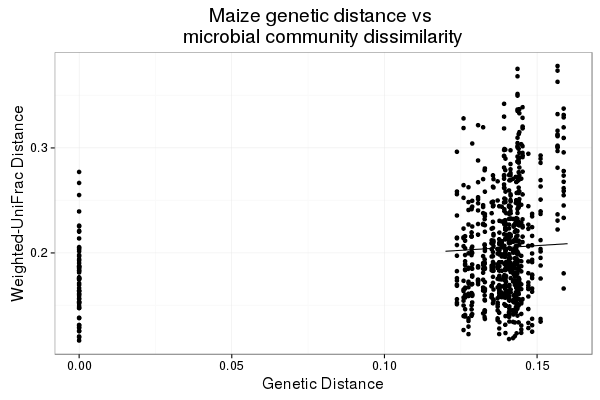

In [22]:
%%R -w 600 -h 400
test <- function(x) {.18*x + 0.18}


                
p = ggplot(Dist, aes(y = w_Unif_Dist, x = gene_Dist)) 
p = p + geom_point() #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .204, se = FALSE)
p = p + theme_bw(base_size = 16)
p = p + ggtitle("Maize genetic distance vs \n microbial community dissimilarity ")
#p = p + stat_smooth(method = lm, se = FALSE)
p = p + stat_function(fun = test, xlim = c(.12, .16))
p = p + ylab("Weighted-UniFrac Distance")
p = p + xlab("Genetic Distance")
p

### Not used, but if date/combo is random effect:

In [ ]:
%%R
Dist$DateCombo = ifelse(as.numeric(as.character(Dist$DAY_A)) < as.numeric(as.character(Dist$DAY_B)),
                                                                    paste(Dist$DAY_A, Dist$DAY_B, sep = "-"), 
                                                                   paste(Dist$DAY_B, Dist$DAY_A, sep = "-"))
Dist$DateCombo %>% unique


In [ ]:
%%R

p = ggplot(Dist, aes(x = gene_Dist, y = w_Unif_Dist))
           p = p + geom_point()
        p = p + stat_smooth(method = "lm", se = FALSE)
           p = p + facet_wrap(~DateCombo)
           p

In [ ]:
# GLS model on early subset of plants

In [ ]:
%%R
Dist$DAY_A %>% unique

In [ ]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, DAY_A %in% c( "53", "57", "61") & DAY_B %in% c( "53", "57", "61"))


dim(SubDist) %>% print
SubDist$PlantA %>% unique

In [ ]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)


In [ ]:
%%R
fit2=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

In [ ]:
%%R
fit3=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

In [ ]:
%%R
fit4=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

In [ ]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

In [ ]:
%%R
fit6=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

# Subset of late season plants

In [ ]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, PlantA %in% c("MS71",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN",    "Mo18") & PlantB %in% c("MS71", "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI",  "HELAN",  "Mo18"))
dim(SubDist) %>% print
SubDist$PlantA %>% unique

In [ ]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [ ]:
%%R
fit2=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

In [ ]:
%%R
fit3=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

In [ ]:
%%R
fit4=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

In [ ]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

In [ ]:
%%R
fit6=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2) + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

In [ ]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

# Maize distance analysis

In [ ]:
%%R
NAM_hc = hclust(as.dist(NAMdist), "average")
plot(NAM_hc)

In [ ]:
%%R
physeq.Maize = subset_samples(physeq.Full, Type == "Maize" & Plant != "75-062")
as(sample_data(physeq.Maize), "data.frame") %>%

group_by(Plant) %>%
   summarise(DATE = first(DAP)) %>% 
    arrange(DATE) %>%
   print()

In [ ]:
%%R
Dist %>% dim %>% print
#Use melt to join genetic distance matrix with unifrac distance
#head(ud.m) ##Use formated unifrac distance from above
#melt 
NAM.m = melt(as.matrix(NAMdist))

#set column names and create comparison column
colnames(NAM.m) = c("PlantA", "PlantB", "gene_Dist")

NAM.m$PlantComp = paste(NAM.m$PlantA, NAM.m$PlantB, sep = "-")
NAM.m %>% head

#Join with unifrac DistanceMatrix
NAMDist = left_join(Dist, NAM.m[,c(3,4)], by = "PlantComp") %>% filter(!is.na(gene_Dist))
NAMDist %>% dim %>% print
NAMDist %>% head

In [ ]:
%%R
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit1)

In [ ]:
%%R
fit2=  gls(w_Unif_Dist ~  SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit2)

In [ ]:
%%R
fit3=  gls(w_Unif_Dist ~ SameDay + LibraryComp + gene_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit3)

In [ ]:
%%R
fit4=  gls(w_Unif_Dist ~  SameDay + LibraryComp + poly(gene_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit4)

In [ ]:
%%R
fit5=  gls(w_Unif_Dist ~ SameDay + LibraryComp + PC1Dist + PC2Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit5)

In [ ]:
%%R
fit6=  gls(w_Unif_Dist ~ SameDay + LibraryComp + poly(gene_Dist,2) + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit6)

# Time vs MCC mantel test

In [ ]:
%%R
sample_data(physeq.Nneg)$DAP

In [ ]:
%%R
sd = sample_data(physeq.Nneg)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Nneg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("DAP")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

In [ ]:
%%R
mcc.correlog <- mantel.correlog(date.wunif.dist, Fun_dist, nperm=99)
summary(mcc.correlog) %>% print
mcc.correlog  %>% print
plot(mcc.correlog) 

# Ignore below this point

# Compare plant phylogenetic distance to l2f

In [ ]:
%%R
# log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'
# l2f = read.csv(log2foldFile, header = TRUE)
# colnames(l2f)

### Spread by plant to make matrix of log2fold change in each OTU by plant combo

In [ ]:
%%R
# df = l2f[,c(1,11,13)]
# l2f_m = spread(df, Plant, log2FoldChange, fill = 0, drop = TRUE)
# rownames(l2f_m) = l2f_m$OTU
# l2f_m = l2f_m[,-1]
# l2f_m %>% head

In [ ]:
%%R
# dim(l2f_m)

### recode all negative log2fold changes with 0

In [ ]:
%%R
# l2f_me = l2f_m
# l2f_me[l2f_me < 0] = 0 
# head(l2f_me)

## Calculate pairwise weighted Unifrac distances between samples

need to figure out how to run unifrac measure outside of phyloseq

In [ ]:
%%R
# physeq.Full

In [ ]:
%%R
# #provide fast tree for unifrac calculation
# #treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'
# #Tree = read.tree(treeFile)
# Tree = phy_tree(physeq.Full)
# str(Tree)


In [ ]:
%%R
# l2f_wunif = picante::unifrac(as.matrix(t(l2f_me)), Tree)

In [ ]:
%%R
# l2f_bray = vegdist(as.matrix(t(l2f_me)), method = "bray")

In [ ]:
%%R
# hc_unif = hclust(l2f_wunif, "average")
# plot(hc_unif) %>% print

# hc_bray = hclust(l2f_bray, "average")
# plot(hc_bray, main = "Cluster Dendrogram, \n Bray-Curtis Distance")

# Mantel test of phylogenetic distance and l2f unifrac distance

### Maize

In [ ]:
%%R
# NAMdist %>% print

# #subset column and rows of log2fold change so that only NAM lines are included
# NLU = as.matrix(l2f_wunif)
# NLU = NLU[c(4,5,11,13:18,22),c(4,5,11,13:18,22)]
# NLU

# NLB = as.matrix(l2f_bray)
# NLB = NLB[c(4,5,11,13:18,22),c(4,5,11,13:18,22)]
# NLB

In [ ]:
%%R
# M1 = mantel(as.dist(NAMdist), as.dist(NLU), method="pearson", permutations=999)
# print(M1)

In [ ]:
%%R
# M1 = mantel(as.dist(NAMdist), as.dist(NLB), method="pearson", permutations=999)
# print(M1)

### Species

In [ ]:
%%R

# #Organize log2fold change distance matrix so that only plants with cholorplast distances are included 
# #and column and row order is congruent with phylogenetic distance matrix
# l2f_wunif.t = as.matrix(l2f_wunif) %>% as.data.frame()
#     temp1 = l2f_wunif.t[c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR"), c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR")]

#     SLU = as.matrix(temp1)

#     SLU = as.dist(SLU)
#     SLU %>% print

# #Remove ginkgo so that matrices are congruent
# p.temp = as.matrix(phydist) %>% as.data.frame()
#     temp2 = p.temp[-12, -12] #remove ginkgo

#     temp2 = as.matrix(temp2)
#     phydist = as.dist(temp2)

#     phydist %>% print

# l2f_bray.t = as.matrix(l2f_bray) %>% as.data.frame()
#     temp2 = l2f_bray.t[c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR"), c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR")]

#     SLB = as.matrix(temp2)
#     SLB = as.dist(SLB)
#     SLB %>% print


In [ ]:
%%R
# m1 = mantel(phydist, SLU, method="pearson", permutations=999)
# print(m1)

In [ ]:
%%R
# m1 = mantel(phydist, SLB, method="pearson", permutations=999)
# print(m1)